Learning to rank.


In [1]:
from wvpy.jtools import declare_task_variables

# set up for external override
with declare_task_variables(globals()):
    rand_seed = 2024
    do_display = True
    result_fname = ""

In [2]:
# set up Python
import logging
import numpy as np
import pandas as pd
from sklearn.linear_model import LogisticRegression
from cmdstanpy import CmdStanModel
from plotnine import *
from rank_plotting_fns import (
    define_Stan_choice_src,
    define_Stan_panel_src,
    format_Stan_data,
    plot_rank_performance,
    run_stan_model,
    sort_observations_frame,
)

# quiet down Stan
logger = logging.getLogger("cmdstanpy")
logger.addHandler(logging.NullHandler())

In [3]:
rng = np.random.default_rng(rand_seed)

In [4]:
example_name = "uci wine example"

In [5]:
if do_display:
    print(example_name)

uci wine example


In [6]:
if example_name == "uci wine example":
    # read data and set scale of system
    features_frame = pd.read_csv("uci_wine_example_features.csv")
    features_scores = pd.read_csv("uci_wine_example_scores.csv")
    score_name = "logistic_score"
    m_examples: int = 100
    noise_scale = 3.87
    position_penalty_scale = -2.7123
elif example_name == "sklearn wine example":
    # read data and set scale of system
    features_frame = pd.read_csv("sklearn_wine_example_features.csv")
    features_scores = pd.read_csv("sklearn_wine_example_scores.csv")
    score_name = "score"
    m_examples: int = 100
    noise_scale = 18.7
    position_penalty_scale = -13.123
else:
    raise ("bad option")

know_score: bool = True

In [7]:
features_frame.head()

,fixed_acidity,volatile_acidity,citric_acid,residual_sugar,chlorides,free_sulfur_dioxide,total_sulfur_dioxide,density,pH,sulphates,alcohol
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4


In [8]:
features_frame.shape

(6497, 11)

In [9]:
collected_stats = []

In [10]:
n_alternatives: int = 5

In [11]:
n_vars = features_frame.shape[1] + n_alternatives

In [12]:
position_penalties = [position_penalty_scale * i for i in range(n_alternatives)]

position_penalties

[-0.0, -2.7123, -5.4246, -8.1369, -10.8492]

In [13]:
# assemble panels of observations with top scoring entry picked
observations = dict()
for sel_i in range(n_alternatives):
    observations[f"display_position_{sel_i}"] = [sel_i] * m_examples
    selected_examples = rng.choice(
        features_frame.shape[0], size=m_examples, replace=True
    )
    observations[f"item_id_{sel_i}"] = selected_examples
    observations[f"score_value_{sel_i}"] = (
        [  # noisy observation of score plus position penalty
            features_scores.loc[int(selected_examples[i]), score_name]  # item score
            + position_penalties[sel_i]  # positional penalty
            + noise_scale * rng.normal(size=1)[0]  # observation noise
            for i in range(m_examples)
        ]
    )
    observations[f"pick_value_{sel_i}"] = [0] * m_examples
observations = pd.DataFrame(observations)
# mark selections
for i in range(m_examples):
    best_j = 0
    for j in range(1, n_alternatives):
        if (
            observations[f"score_value_{j}"][i]
            > observations[f"score_value_{best_j}"][i]
        ):
            best_j = j
    observations.loc[i, f"pick_value_{best_j}"] = 1
# make sure we don't have a column we would not know in practice
observations = observations.loc[
    :, [c for c in observations.columns if not c.startswith("score_value_")]
].reset_index(drop=True, inplace=False)

observations.head()

,display_position_0,item_id_0,pick_value_0,display_position_1,item_id_1,pick_value_1,display_position_2,item_id_2,pick_value_2,display_position_3,item_id_3,pick_value_3,display_position_4,item_id_4,pick_value_4
0,0,1569,0,1,1754,0,2,6425,1,3,2780,0,4,2646,0
1,0,4390,1,1,2031,0,2,2692,0,3,4416,0,4,1913,0
2,0,599,1,1,1808,0,2,64,0,3,59,0,4,1671,0
3,0,1392,0,1,2324,0,2,5815,0,3,1819,1,4,4567,0
4,0,2063,0,1,6283,0,2,3610,1,3,2085,0,4,5610,0


In [14]:
observations.loc[
    :, [c for c in observations.columns if c.startswith("pick_value_")]
].mean(axis=0)

pick_value_0    0.51
pick_value_1    0.32
pick_value_2    0.10
pick_value_3    0.06
pick_value_4    0.01
dtype: float64

In [15]:
# This is the data
observations[
    [c for c in observations.columns if not c.startswith("display_position_")]
].head(10)

,item_id_0,pick_value_0,item_id_1,pick_value_1,item_id_2,pick_value_2,item_id_3,pick_value_3,item_id_4,pick_value_4
0,1569,0,1754,0,6425,1,2780,0,2646,0
1,4390,1,2031,0,2692,0,4416,0,1913,0
2,599,1,1808,0,64,0,59,0,1671,0
3,1392,0,2324,0,5815,0,1819,1,4567,0
4,2063,0,6283,0,3610,1,2085,0,5610,0
5,2010,1,1465,0,6388,0,25,0,420,0
6,5903,1,1374,0,312,0,926,0,5467,0
7,5194,1,3651,0,1494,0,1749,0,5865,0
8,5946,1,4527,0,5988,0,3021,0,4821,0
9,6469,1,6044,0,2787,0,5786,0,3709,0


In [16]:
score_compare_frame = pd.DataFrame([[] for i in range(features_frame.shape[0])])
if know_score:
    score_compare_frame["hidden concept"] = features_scores[
        score_name
    ]  # would not know this for non-synthetic data

Try a Stan model.


In [17]:
observations_sorted = sort_observations_frame(observations)

In [18]:
observations_sorted.head(10)

,encoding_0,item_id_0,pick_value_0,encoding_1,item_id_1,pick_value_1,encoding_2,item_id_2,pick_value_2,encoding_3,item_id_3,pick_value_3,encoding_4,item_id_4,pick_value_4
0,2,6425,1,1,1754,0,0,1569,0,3,2780,0,4,2646,0
1,0,4390,1,1,2031,0,2,2692,0,3,4416,0,4,1913,0
2,0,599,1,1,1808,0,2,64,0,3,59,0,4,1671,0
3,3,1819,1,1,2324,0,2,5815,0,0,1392,0,4,4567,0
4,2,3610,1,1,6283,0,0,2063,0,3,2085,0,4,5610,0
5,0,2010,1,1,1465,0,2,6388,0,3,25,0,4,420,0
6,0,5903,1,1,1374,0,2,312,0,3,926,0,4,5467,0
7,0,5194,1,1,3651,0,2,1494,0,3,1749,0,4,5865,0
8,0,5946,1,1,4527,0,2,5988,0,3,3021,0,4,4821,0
9,0,6469,1,1,6044,0,2,2787,0,3,5786,0,4,3709,0


In [19]:
observations_sorted[
    [c for c in observations_sorted.columns if not c.startswith("pick_value_")]
].head(10)

,encoding_0,item_id_0,encoding_1,item_id_1,encoding_2,item_id_2,encoding_3,item_id_3,encoding_4,item_id_4
0,2,6425,1,1754,0,1569,3,2780,4,2646
1,0,4390,1,2031,2,2692,3,4416,4,1913
2,0,599,1,1808,2,64,3,59,4,1671
3,3,1819,1,2324,2,5815,0,1392,4,4567
4,2,3610,1,6283,0,2063,3,2085,4,5610
5,0,2010,1,1465,2,6388,3,25,4,420
6,0,5903,1,1374,2,312,3,926,4,5467
7,0,5194,1,3651,2,1494,3,1749,4,5865
8,0,5946,1,4527,2,5988,3,3021,4,4821
9,0,6469,1,6044,2,2787,3,5786,4,3709


In [20]:
assert np.all(observations_sorted["pick_value_0"] == 1)
for sel_i in range(1, n_alternatives):
    assert np.all(observations_sorted[f"pick_value_{sel_i}"] == 0)

In [21]:
stan_model_panel_src = define_Stan_panel_src(n_alternatives=n_alternatives)

if do_display:
    print(stan_model_panel_src)


data {
  int<lower=1> n_vars;                     // number of variables per alternative
  int<lower=1> m_examples;                 // number of examples
  matrix[m_examples, n_vars] x_picked;     // character of picked examples
  matrix[m_examples, n_vars] x_passed_1;   // character of passed examples
  matrix[m_examples, n_vars] x_passed_2;   // character of passed examples
  matrix[m_examples, n_vars] x_passed_3;   // character of passed examples
  matrix[m_examples, n_vars] x_passed_4;   // character of passed examples
}
parameters {
  vector[n_vars] beta;                      // model parameters
  vector[m_examples] error_picked;          // reified noise term on picks (the secret sauce!)
}
transformed parameters {
  vector[m_examples] expect_picked;
  vector[m_examples] v_picked;
  vector[m_examples] expect_passed_1;
  vector[m_examples] expect_passed_2;
  vector[m_examples] expect_passed_3;
  vector[m_examples] expect_passed_4;
  expect_picked = x_picked * beta;          // mod

In [22]:
data_str = format_Stan_data(
    observations_sorted=observations_sorted,
    features_frame=features_frame,
)

In [23]:
fit = run_stan_model(
    stan_model_src=stan_model_panel_src,
    data_str=data_str,
)

In [24]:
# get implied sample weights from chain
wt_frame = fit.draws_pd(vars=["lp__"])

wt_frame

,lp__
0,-143.168
1,-141.712
2,-146.994
3,-147.231
4,-151.910
...,...
3995,-151.783
3996,-140.738
3997,-131.348
3998,-138.079


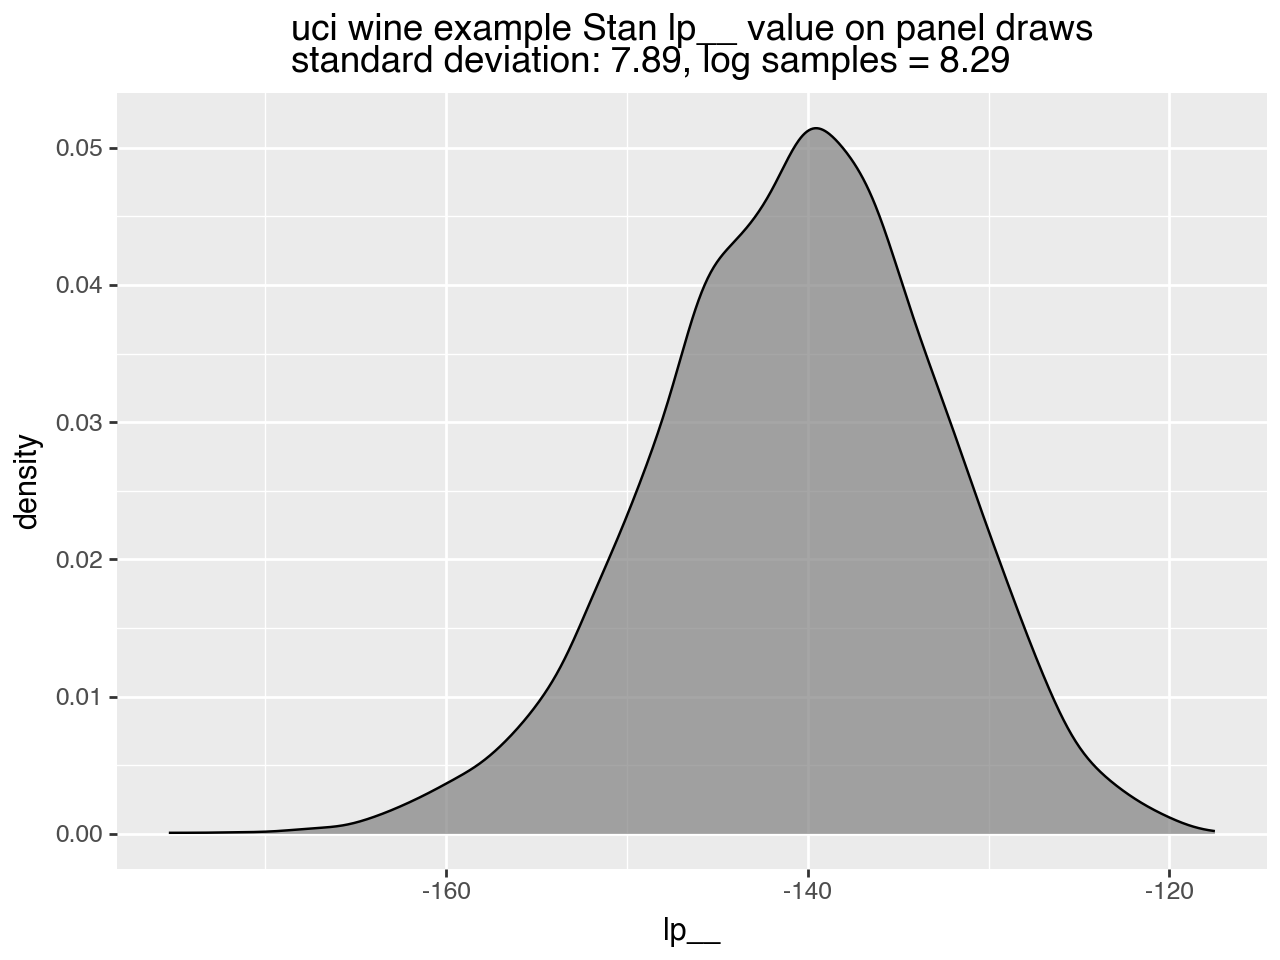

In [25]:
if do_display:
    stddev = np.sqrt(np.var(wt_frame["lp__"]))
    log_samples = np.log(wt_frame.shape[0])
    (
        ggplot(
            data=wt_frame,
            mapping=aes(x="lp__"),
        )
        + geom_density(fill="gray", alpha=0.7)
        + ggtitle(
            f"{example_name} Stan lp__ value on panel draws\nstandard deviation: {stddev:.2f}, log samples = {log_samples:.2f}"
        )
    ).show()

In [26]:
beta_draws = fit.draws_pd(vars=["beta"])
beta_draws_display = beta_draws.copy()
beta_draws_display.columns = list(features_frame.columns) + [
    f"position_effect_{sel_i}" for sel_i in range(n_alternatives)
]

beta_draws_display

,fixed_acidity,volatile_acidity,citric_acid,residual_sugar,chlorides,free_sulfur_dioxide,total_sulfur_dioxide,density,pH,sulphates,alcohol,position_effect_0,position_effect_1,position_effect_2,position_effect_3,position_effect_4
0,-0.180566,1.807740,16.30970,-0.536857,-8.64719,-0.031294,0.041431,2.351410,11.21300,9.53091,-0.633882,15.52600,12.206300,4.057850,1.26079,-11.808800
1,1.668120,-6.143740,-14.97090,1.003750,13.98260,0.058503,-0.022488,-1.654480,8.61518,9.16815,5.483620,9.34159,1.432950,-2.114280,-12.45490,-21.358900
2,0.925205,-5.862720,-12.58260,1.034080,10.99560,0.109493,-0.044234,7.401250,7.54334,7.75551,4.300040,9.25750,1.864030,-4.975850,-15.59720,-20.544400
3,-0.111133,0.154558,-8.96566,0.290412,-21.82460,0.028030,0.009542,-6.785220,11.63510,5.36700,3.025830,6.93378,2.975450,-4.891260,-6.30761,-16.980100
4,0.630930,-0.872713,5.79252,0.044867,5.11565,0.123649,0.003909,2.391250,-1.81037,11.70640,2.202310,4.11826,-2.702770,-9.568960,-16.20950,-20.052700
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3995,1.674970,-1.981820,-5.37776,0.614453,-11.74920,0.036817,0.004996,-5.309000,4.07558,1.60368,3.250400,17.54060,11.432300,2.995500,2.60861,-0.196363
3996,0.679775,-7.003220,-6.39398,-0.115578,-1.21275,-0.049308,0.050499,10.165700,12.54930,15.16540,1.667320,10.27080,3.268270,-1.832520,-8.10847,-10.289100
3997,0.702541,1.503680,2.77072,0.480985,3.48360,-0.001414,-0.012643,0.298049,2.49759,2.75561,3.232650,13.97040,9.887790,1.375310,-6.19798,-11.694500
3998,1.155090,-11.328000,-5.78857,0.003915,-1.19564,0.005274,0.027784,14.832300,15.52590,12.83800,1.952300,11.63040,6.732830,-0.424271,-5.06837,-18.159000


In [27]:
# this this entirety of what we pull out of Stan- per modeled preference cohort
# from now on we do not use Stan
estimated_beta_Stan = beta_draws_display.loc[
    wt_frame["lp__"] >= np.quantile(wt_frame["lp__"], 0.9), :
].mean()
# estimated_beta_Stan = beta_draws_display.mean()
estimated_beta_Stan

fixed_acidity            0.534520
volatile_acidity        -2.875023
citric_acid             -3.215551
residual_sugar           0.228050
chlorides                0.343320
free_sulfur_dioxide     -0.023257
total_sulfur_dioxide     0.006856
density                  0.572245
pH                       6.042102
sulphates                5.377272
alcohol                  1.966097
position_effect_0       11.527222
position_effect_1        6.769709
position_effect_2       -1.066747
position_effect_3       -3.937372
position_effect_4      -11.399404
dtype: float64

In [28]:
position_quantiles = (
    beta_draws.iloc[:, features_frame.shape[1] : n_vars]
    .quantile((0.25, 0.5, 0.75))
    .transpose()
    .reset_index(drop=True, inplace=False)
)
position_quantiles.columns = [str(c) for c in position_quantiles.columns]

estimated position influences


,position,estimated effect,actual effect,0.25,0.5,0.75
0,posn_0,11.527222,-0.0000,8.237240,11.684050,14.922600
1,posn_1,6.769709,-2.7123,3.332418,6.799370,9.938235
2,posn_2,-1.066747,-5.4246,-4.535112,-1.207070,2.053140
3,posn_3,-3.937372,-8.1369,-7.790215,-4.393765,-0.835940
4,posn_4,-11.399404,-10.8492,-16.155850,-12.215200,-8.378365


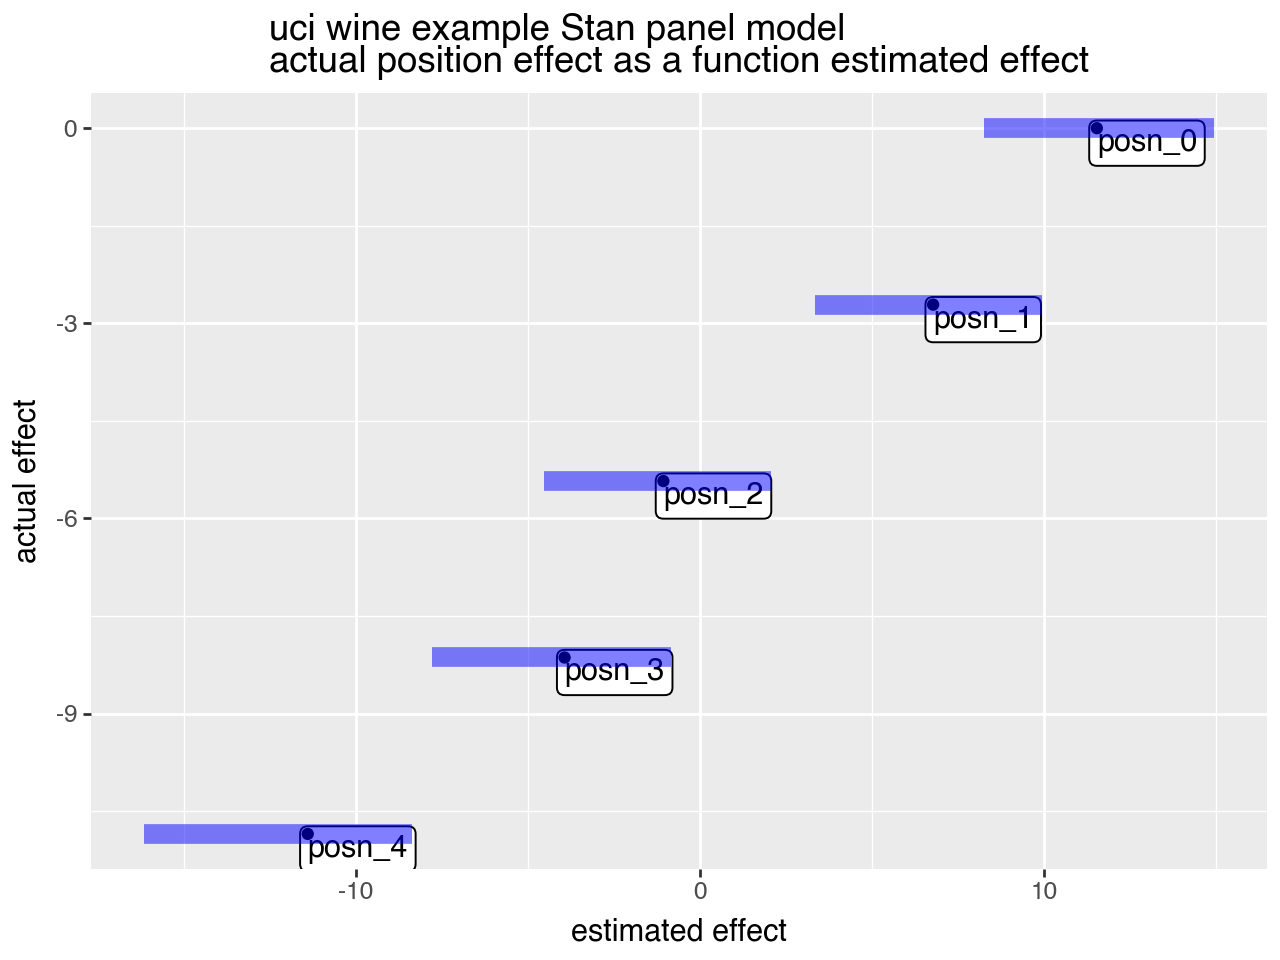

picks


,row,position,pick probability estimate,was pick
0,0,0,0.6547,False
1,0,1,0.1738,False
2,0,2,0.1227,True
3,0,3,0.0420,False
4,0,4,0.0068,False
5,1,0,0.4472,True
6,1,1,0.2925,False
7,1,2,0.1107,False
8,1,3,0.1321,False
9,1,4,0.0175,False


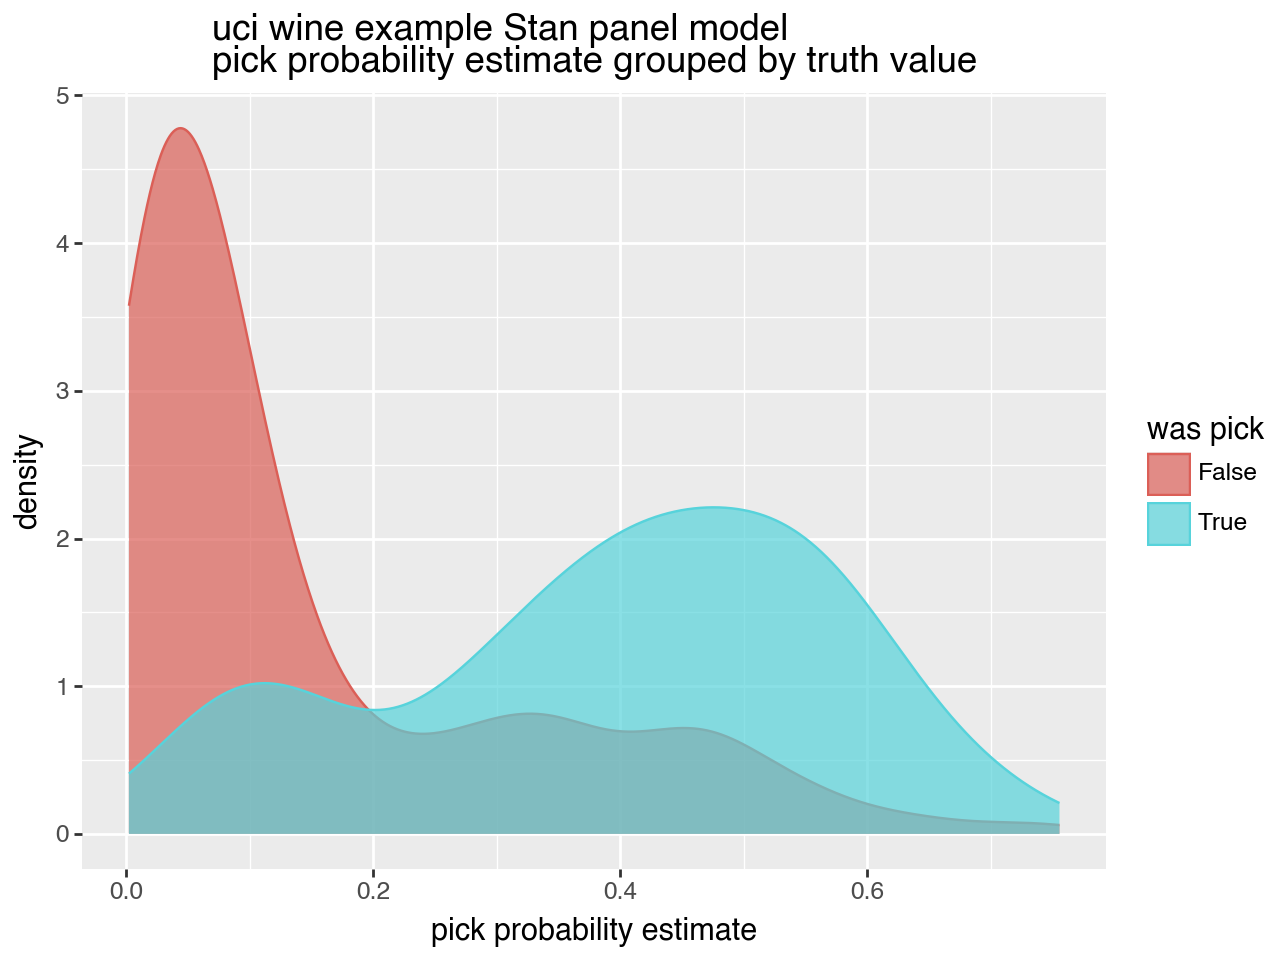

<Figure size 640x480 with 0 Axes>

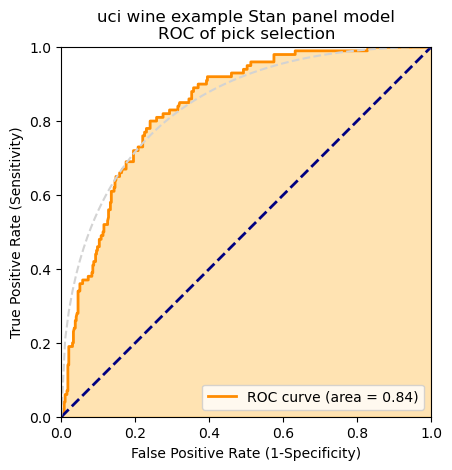

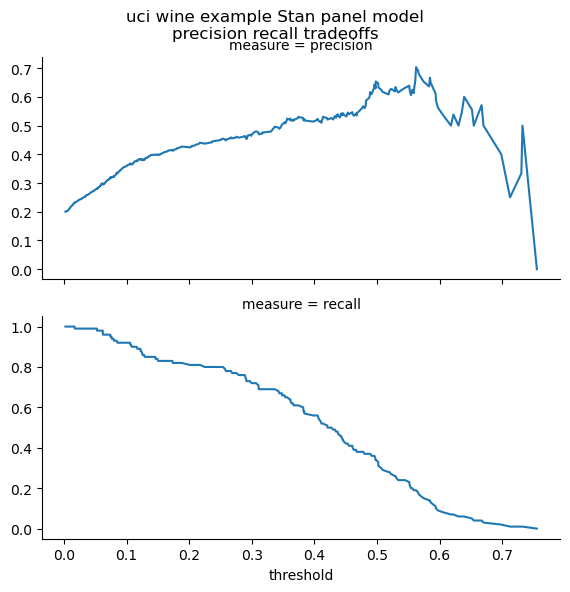

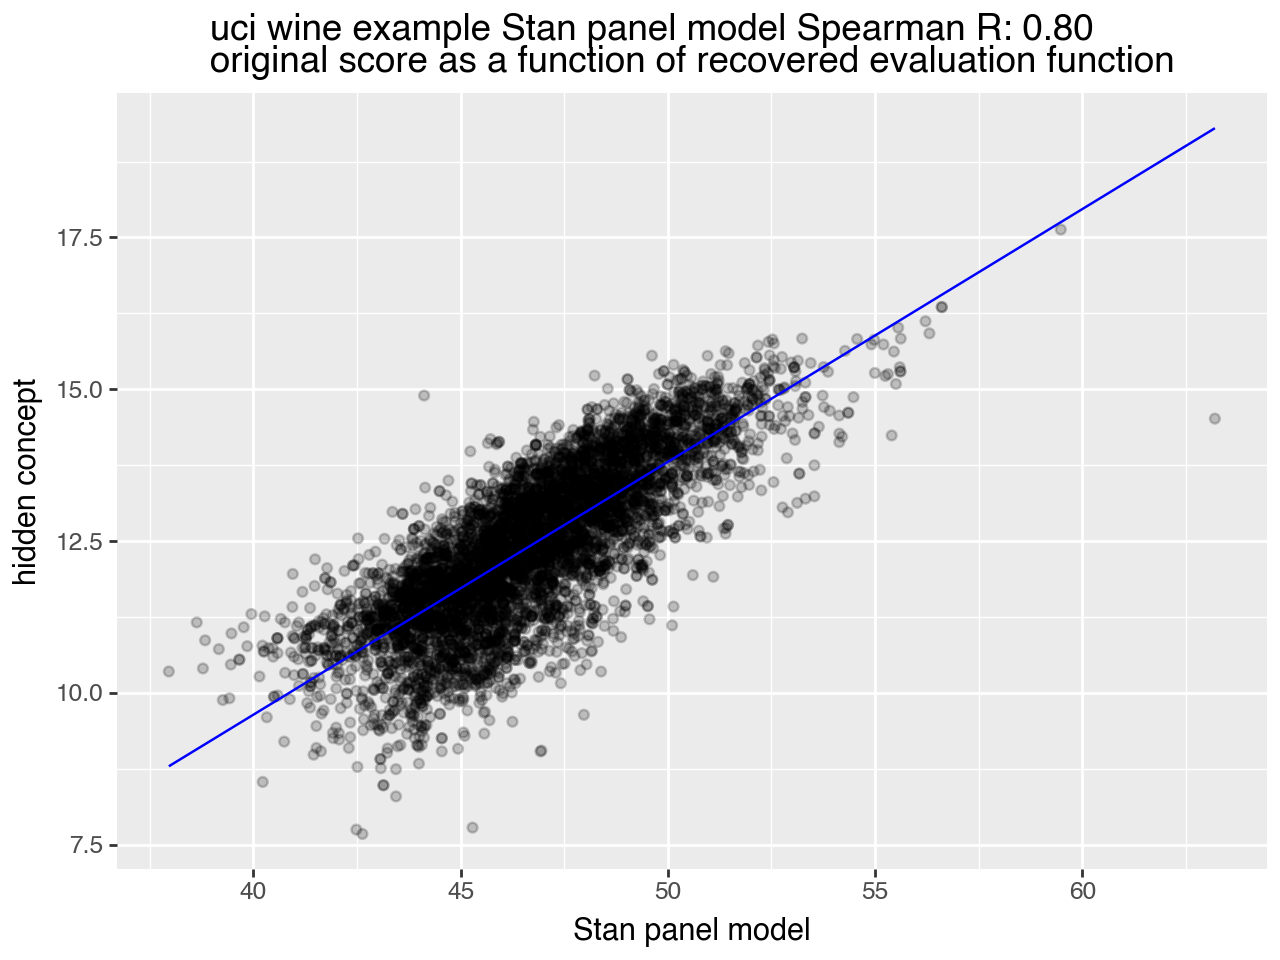

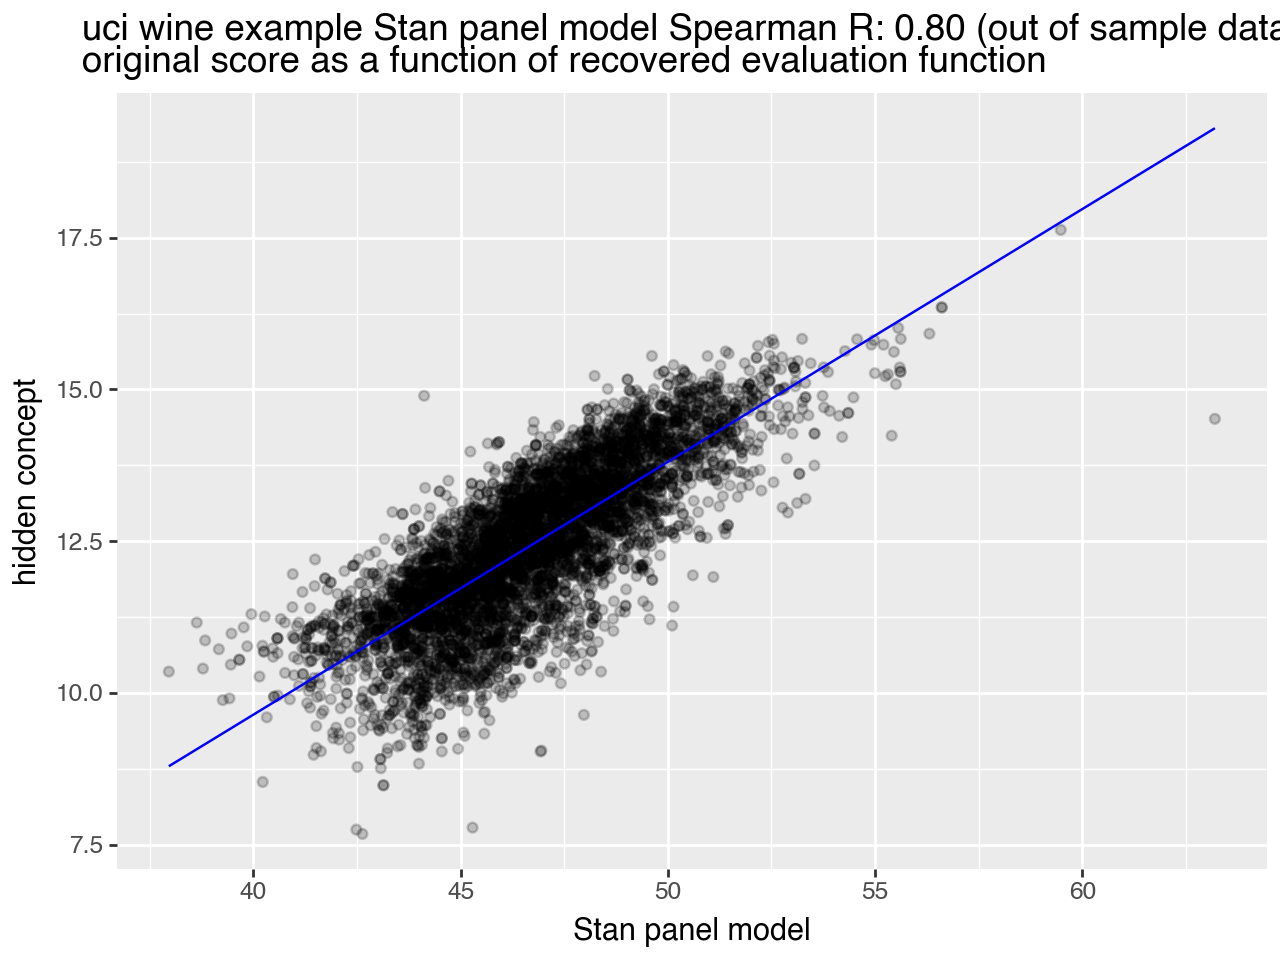

In [29]:
stat_pull = plot_rank_performance(
    estimated_beta=estimated_beta_Stan,  # estimated coefficients
    example_name=example_name,  # name of data set
    n_vars=n_vars,  # number of variables (including position variables)
    n_alternatives=n_alternatives,  # size of panels
    features_frame=features_frame,  # features by row id
    observations=observations,  # observations layout frame
    estimate_name="Stan panel model",  # display name of estimate
    position_quantiles=position_quantiles,  # quantiles of estimated positions
    position_penalties=position_penalties,  # ideal position penalties
    score_compare_frame=score_compare_frame,  # score comparison frame (altered by call)
    rng=rng,  # pseudo random source
    show_plots=do_display,
)
collected_stats.append(stat_pull)

Try to approximate the Stan model with a logistic model with similar error structure.
Consider each pair of panel entries with a different outcome as an observation and try to
build a model that reproduces the observed outcomes.
The extra trick is: repeat the whole data frame negated with the outcomes reverse (so 
we don't define a problem with all positive or all negative outcomes).


In [30]:
feature_names = list(features_frame.columns) + [
    f"position_{sel_i}" for sel_i in range(n_alternatives)
]
enc_frame = []
for row_i in range(observations.shape[0]):
    feature_row = observations.loc[row_i, :]
    sel_pick = np.argmax(
        feature_row[[f"pick_value_{sel_i}" for sel_i in range(n_alternatives)]]
    )
    for sel_i in range(n_alternatives):
        if sel_i != sel_pick:
            posn_vec = [0] * n_alternatives
            posn_vec[sel_pick] = 1.0
            posn_vec[sel_i] = -1.0
            encoded_row = (
                list(
                    features_frame.loc[feature_row[f"item_id_{sel_pick}"], :]
                    - features_frame.loc[feature_row[f"item_id_{sel_i}"], :]
                )
                + posn_vec
            )
            di = pd.DataFrame({k: [v] for k, v in zip(feature_names, encoded_row)})
            enc_frame.append(di)
enc_frame = pd.concat(enc_frame, ignore_index=True)

In [31]:
enc_frame.head()

,fixed_acidity,volatile_acidity,citric_acid,residual_sugar,chlorides,free_sulfur_dioxide,total_sulfur_dioxide,density,pH,sulphates,alcohol,position_0,position_1,position_2,position_3,position_4
0,-0.2,-0.170,0.15,4.2,-0.010,14.0,100.0,0.00066,0.00,0.00,-0.8,-1.0,0.0,1.0,0.0,0.0
1,-1.4,0.100,-0.13,-7.9,-0.020,-19.0,-64.0,-0.00328,0.59,0.15,1.8,0.0,-1.0,1.0,0.0,0.0
2,-1.5,-0.080,-0.16,-3.0,0.017,9.0,9.0,-0.00138,0.36,0.21,0.6,0.0,0.0,1.0,-1.0,0.0
3,-1.0,0.030,-0.23,4.4,0.017,24.0,73.0,0.00282,0.41,0.14,0.3,0.0,0.0,1.0,0.0,-1.0
4,-0.8,0.095,0.17,5.7,0.002,-12.5,-25.0,0.00264,0.04,-0.12,-0.7,1.0,-1.0,0.0,0.0,0.0


In [32]:
logistic_model = LogisticRegression(max_iter=10000, solver="newton-cholesky")
logistic_model.fit(
    pd.concat([enc_frame, -enc_frame], ignore_index=True),
    [True] * enc_frame.shape[0] + [False] * enc_frame.shape[0],
)

LogisticRegression(max_iter=10000, solver='newton-cholesky')

estimated position influences


,position,estimated effect,actual effect
0,posn_0,1.700493,-0.0000
1,posn_1,1.039723,-2.7123
2,posn_2,-0.100792,-5.4246
3,posn_3,-0.581897,-8.1369
4,posn_4,-2.057526,-10.8492


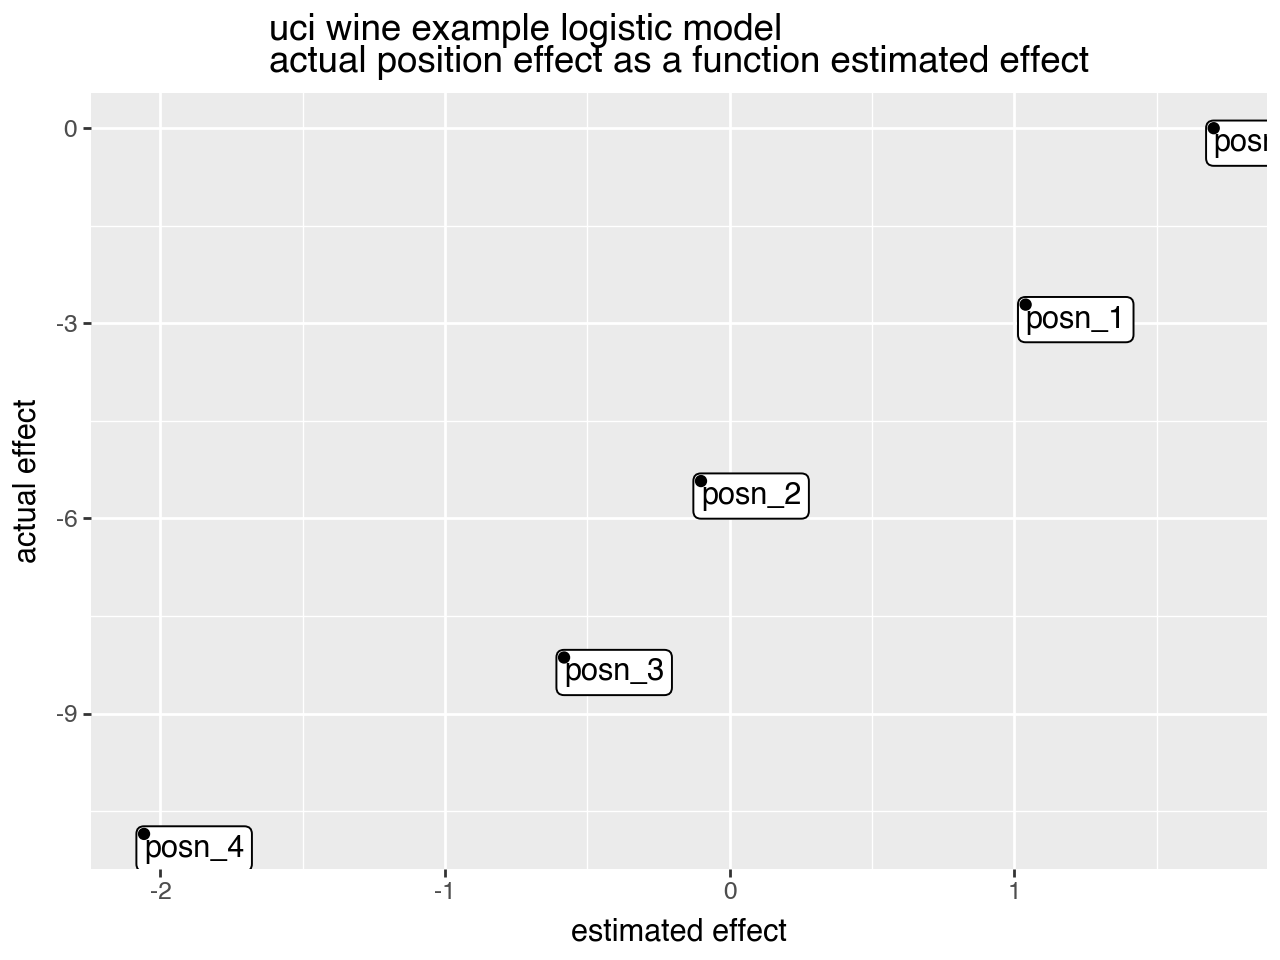

picks


,row,position,pick probability estimate,was pick
0,0,0,0.2618,False
1,0,1,0.2205,False
2,0,2,0.2082,True
3,0,3,0.1775,False
4,0,4,0.1320,False
5,1,0,0.2349,True
6,1,1,0.2231,False
7,1,2,0.1996,False
8,1,3,0.1982,False
9,1,4,0.1442,False


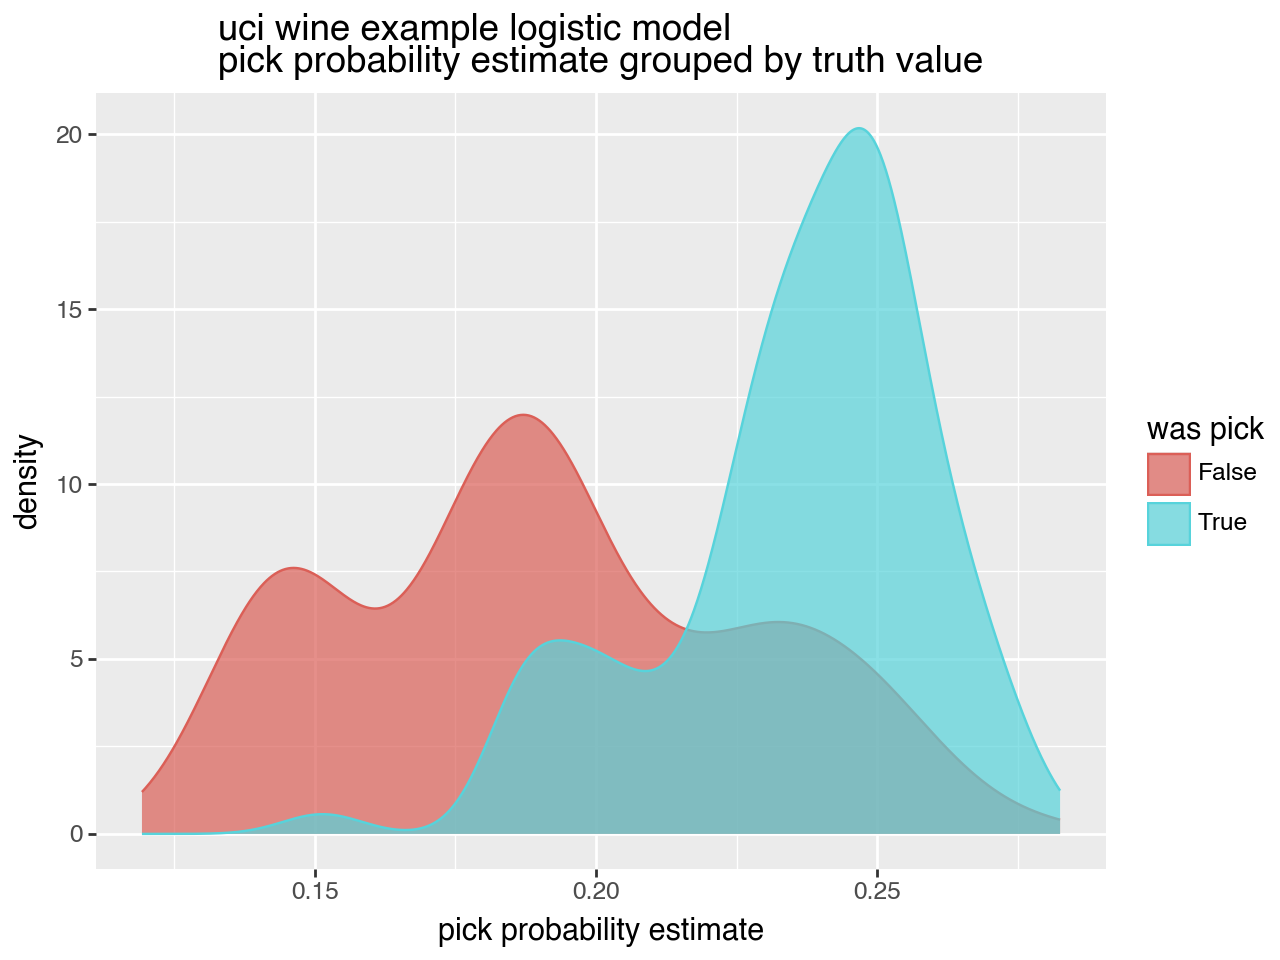

<Figure size 640x480 with 0 Axes>

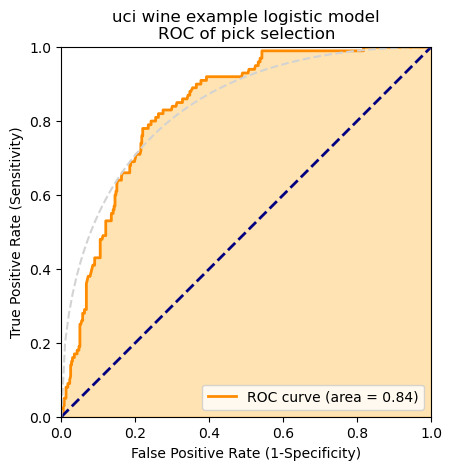

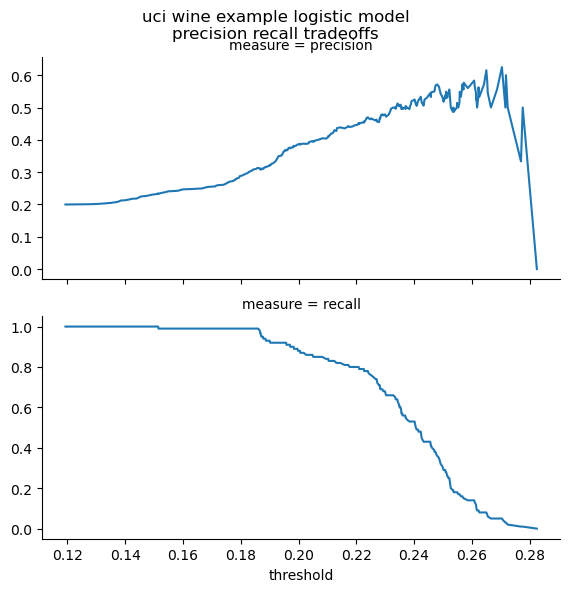

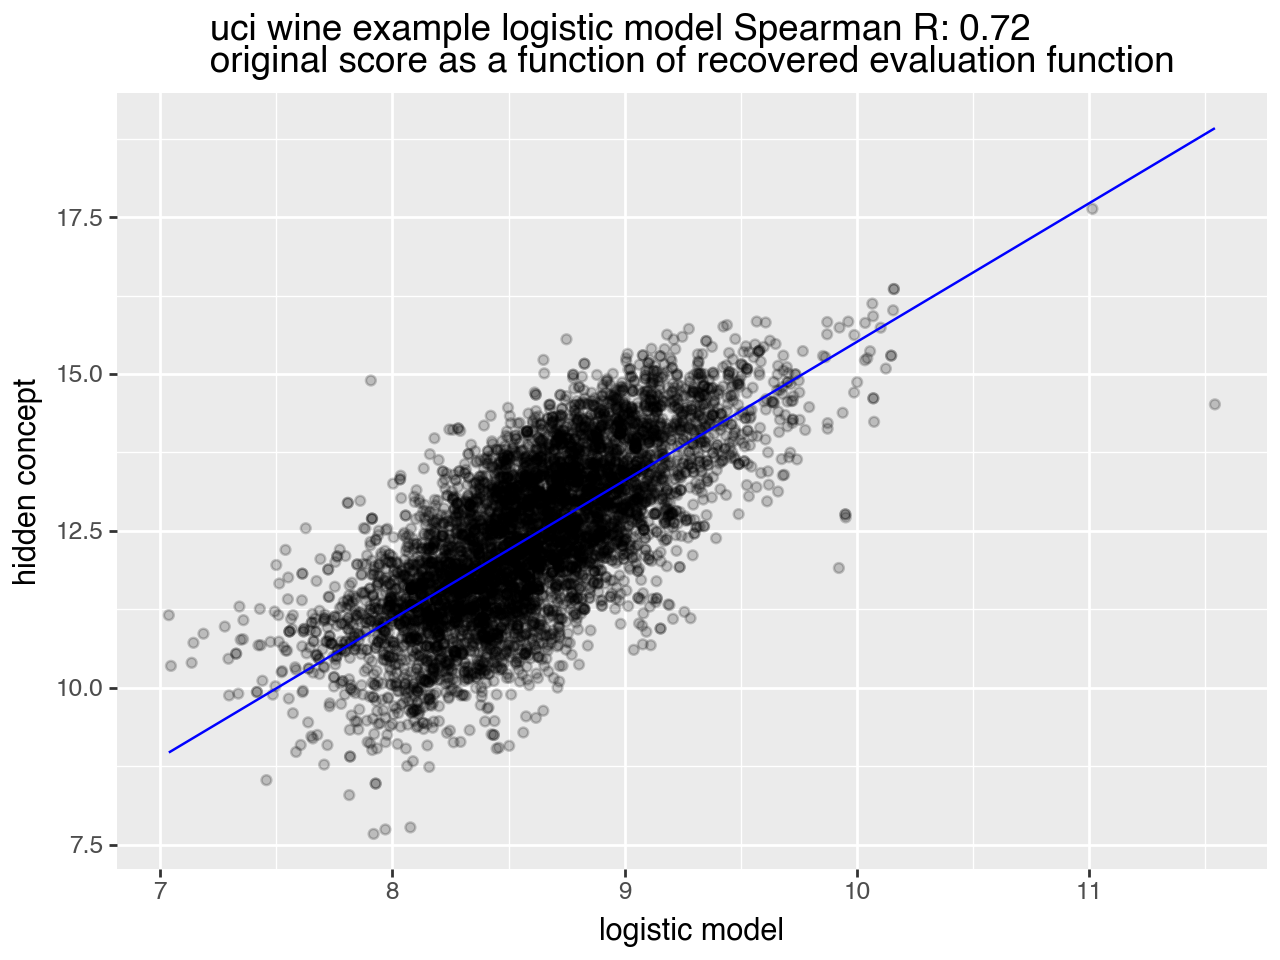

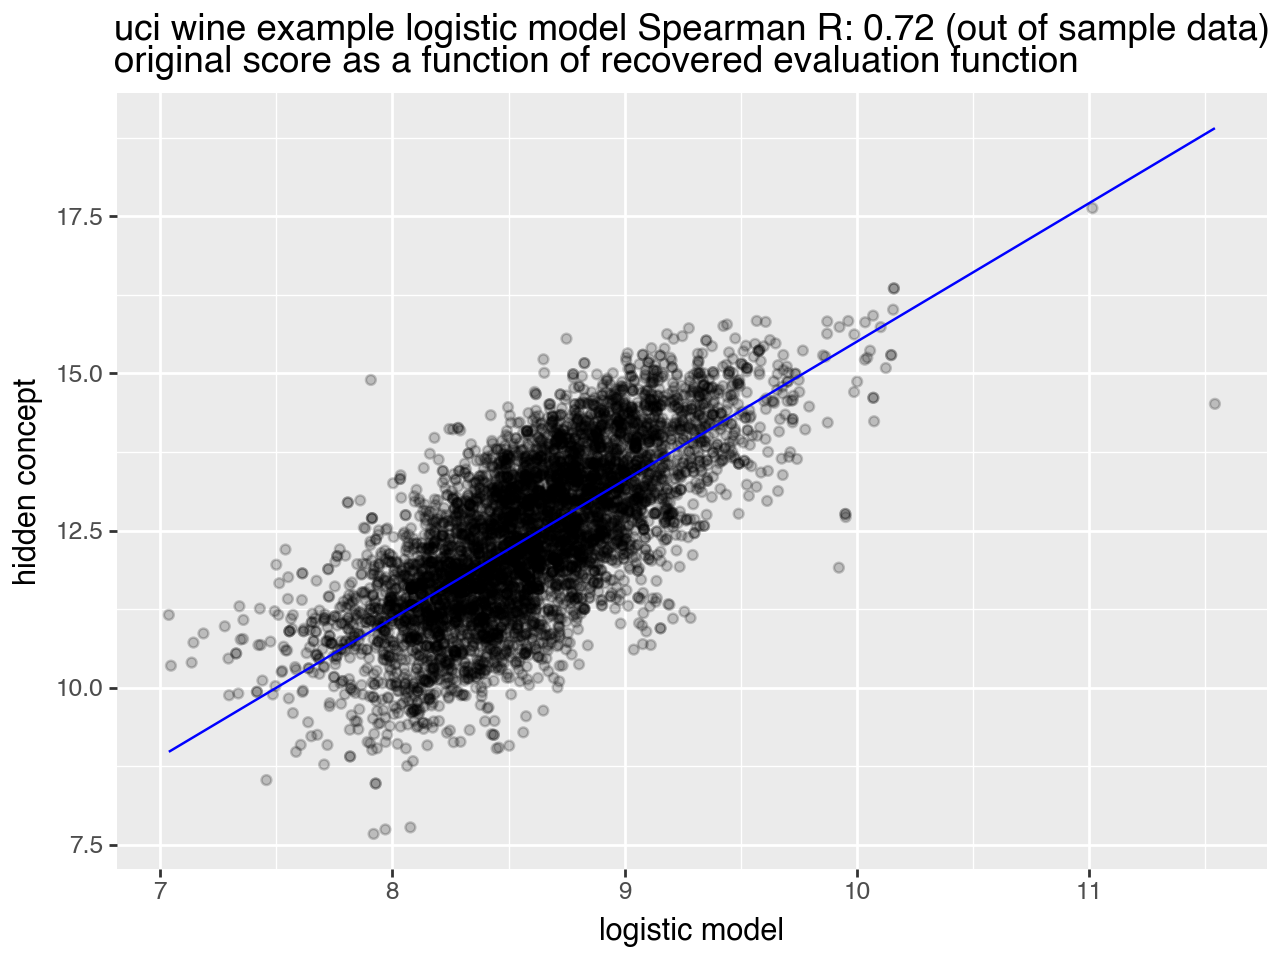

In [33]:
stat_pull = plot_rank_performance(
    estimated_beta=logistic_model.coef_[0],  # estimated coefficients
    example_name=example_name,  # name of data set
    n_vars=n_vars,  # number of variables (including position variables)
    n_alternatives=n_alternatives,  # size of panels
    features_frame=features_frame,  # features by row id
    observations=observations,  # observations layout frame
    estimate_name="logistic model",  # display name of estimate
    position_quantiles=None,  # quantiles of estimated positions
    position_penalties=position_penalties,  # ideal position penalties
    score_compare_frame=score_compare_frame,  # score comparison frame (altered by call)
    rng=rng,  # pseudo random source
    show_plots=do_display,
)
collected_stats.append(stat_pull)

We can also try a related Stan model per-comparison, instead of per-panel.

In [34]:
stan_model_comparison_src = define_Stan_choice_src(n_alternatives=n_alternatives)

if do_display:
    print(stan_model_comparison_src)


data {
  int<lower=1> n_vars;                     // number of variables per alternative
  int<lower=1> m_examples;                 // number of examples
  matrix[m_examples, n_vars] x_picked;     // character of picked examples
  matrix[m_examples, n_vars] x_passed_1;   // character of passed examples
  matrix[m_examples, n_vars] x_passed_2;   // character of passed examples
  matrix[m_examples, n_vars] x_passed_3;   // character of passed examples
  matrix[m_examples, n_vars] x_passed_4;   // character of passed examples
}
parameters {
  vector[n_vars] beta;                      // model parameters
}
transformed parameters {
  vector[m_examples] expect_picked;
  vector[m_examples] expect_passed_1;
  vector[m_examples] expect_passed_2;
  vector[m_examples] expect_passed_3;
  vector[m_examples] expect_passed_4;
  expect_picked = x_picked * beta;          // modeled expected score of picked item
  expect_passed_1 = x_passed_1 * beta;      // modeled expected score of passed item
  expe

In [35]:
fit_comp = run_stan_model(
    stan_model_src=stan_model_comparison_src,
    data_str=data_str,
)

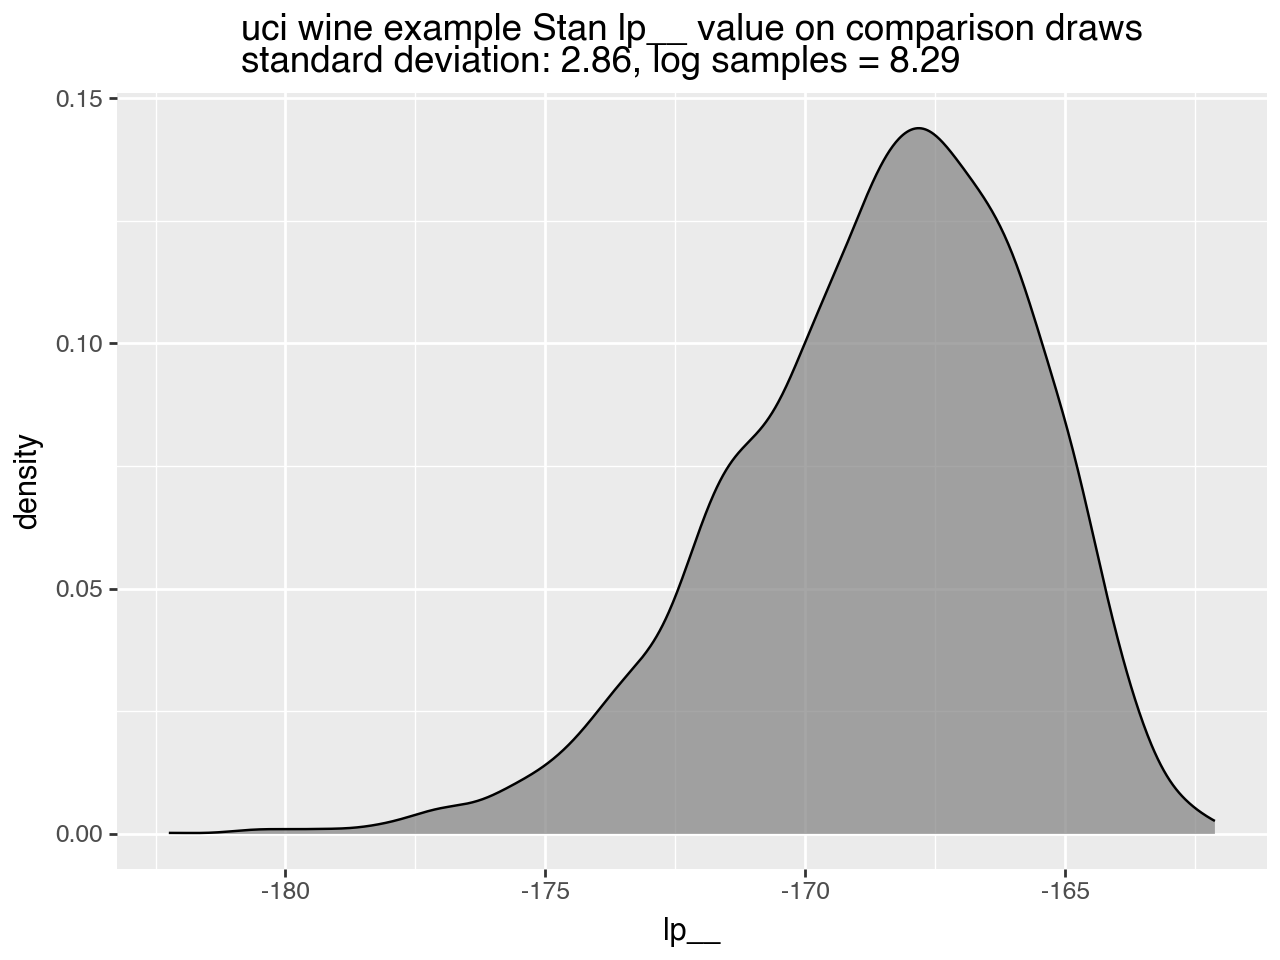

In [36]:
# get implied sample weights from chain
wt_frame_c = fit_comp.draws_pd(vars=["lp__"])
if do_display:
    stddev_c = np.sqrt(np.var(wt_frame_c["lp__"]))
    log_samples_c = np.log(wt_frame_c.shape[0])
    (
        ggplot(
            data=wt_frame_c,
            mapping=aes(x="lp__"),
        )
        + geom_density(fill="gray", alpha=0.7)
        + ggtitle(
            f"{example_name} Stan lp__ value on comparison draws\nstandard deviation: {stddev_c:.2f}, log samples = {log_samples_c:.2f}"
        )
    ).show()

In [37]:
beta_draws_c = fit_comp.draws_pd(vars=["beta"])
estimated_beta_Stan_c = beta_draws_c.loc[
    wt_frame_c["lp__"] >= np.quantile(wt_frame_c["lp__"], 0.9), :
].mean()
# estimated_beta_Stan_c = beta_draws_c.mean()

In [38]:
position_quantiles_c = (
    beta_draws_c.iloc[:, features_frame.shape[1] : n_vars]
    .quantile((0.25, 0.5, 0.75))
    .transpose()
    .reset_index(drop=True, inplace=False)
)
position_quantiles_c.columns = [str(c) for c in position_quantiles_c.columns]

estimated position influences


,position,estimated effect,actual effect,0.25,0.5,0.75
0,posn_0,14.071071,-0.0000,10.837925,14.122150,17.340425
1,posn_1,8.693794,-2.7123,5.498615,8.764845,12.164075
2,posn_2,-0.858264,-5.4246,-4.218150,-1.056700,2.471312
3,posn_3,-5.033926,-8.1369,-8.679047,-5.275955,-1.803050
4,posn_4,-16.268901,-10.8492,-20.284150,-16.827050,-13.163850


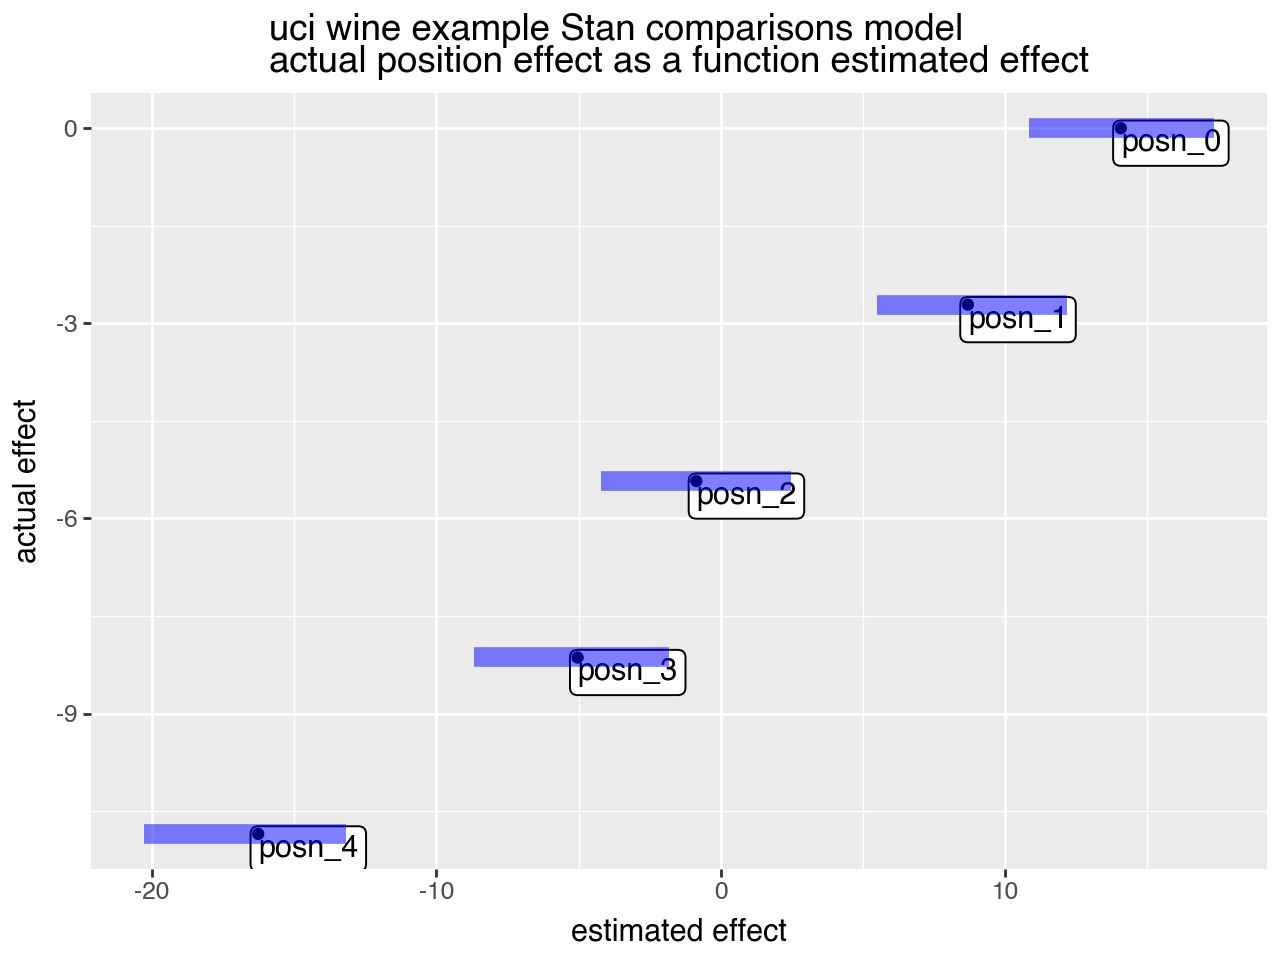

picks


,row,position,pick probability estimate,was pick
0,0,0,0.6790,False
1,0,1,0.1801,False
2,0,2,0.1184,True
3,0,3,0.0217,False
4,0,4,0.0008,False
5,1,0,0.4566,True
6,1,1,0.3386,False
7,1,2,0.1093,False
8,1,3,0.0917,False
9,1,4,0.0038,False


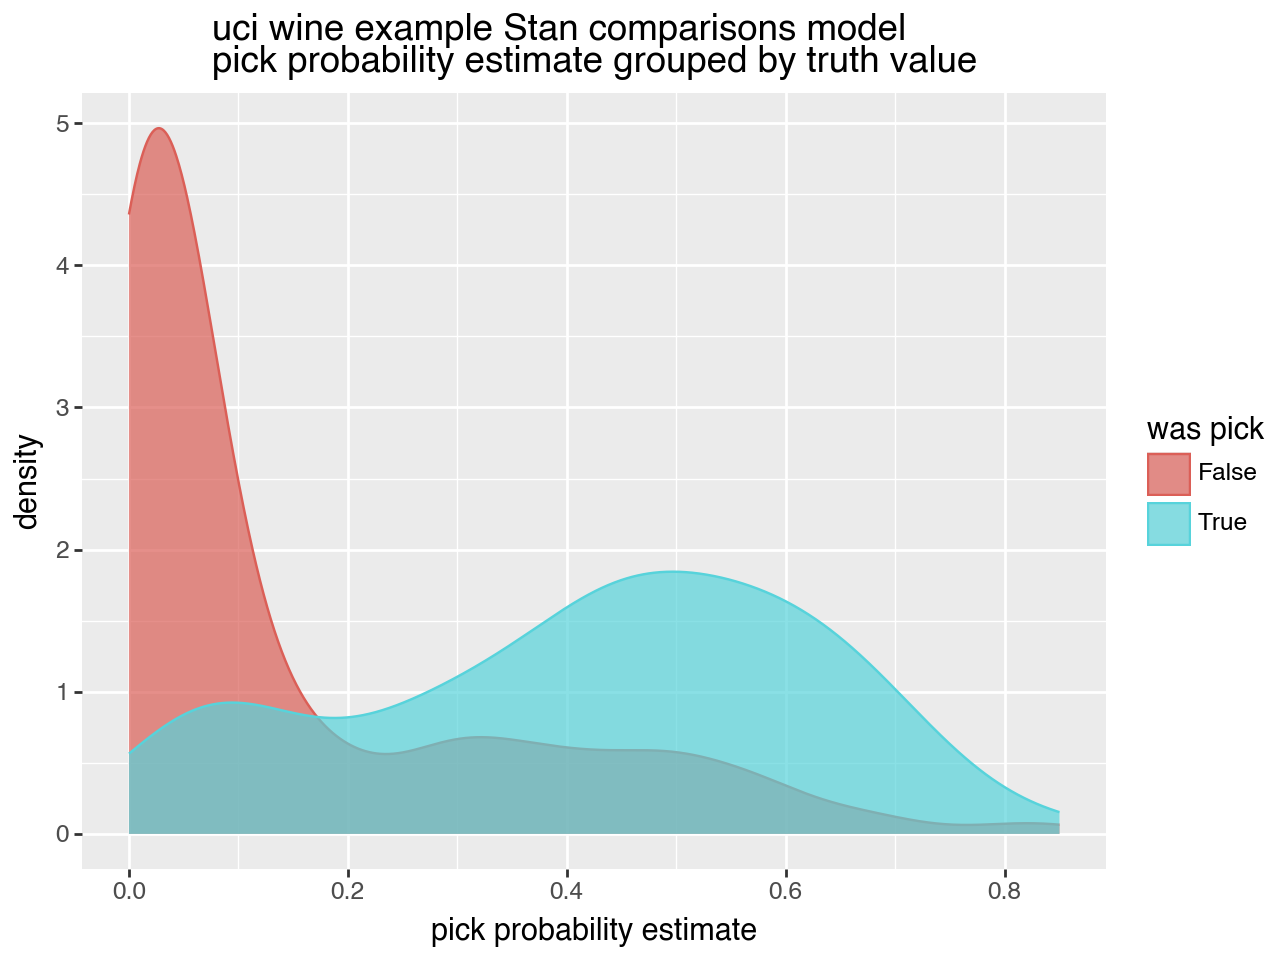

<Figure size 640x480 with 0 Axes>

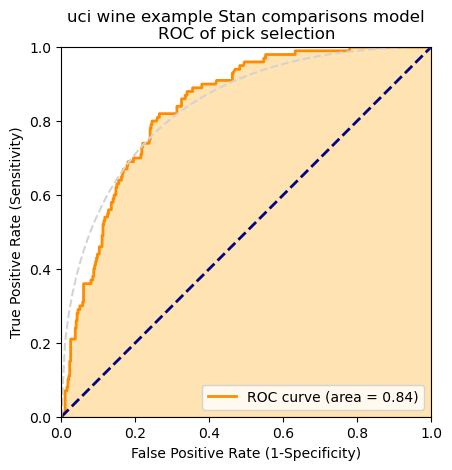

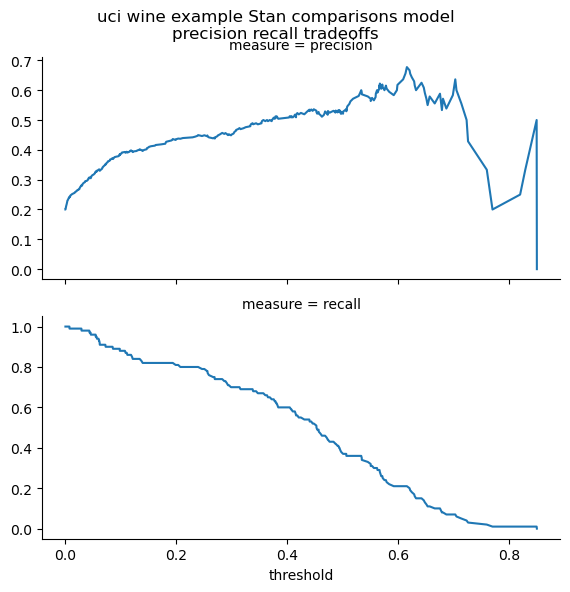

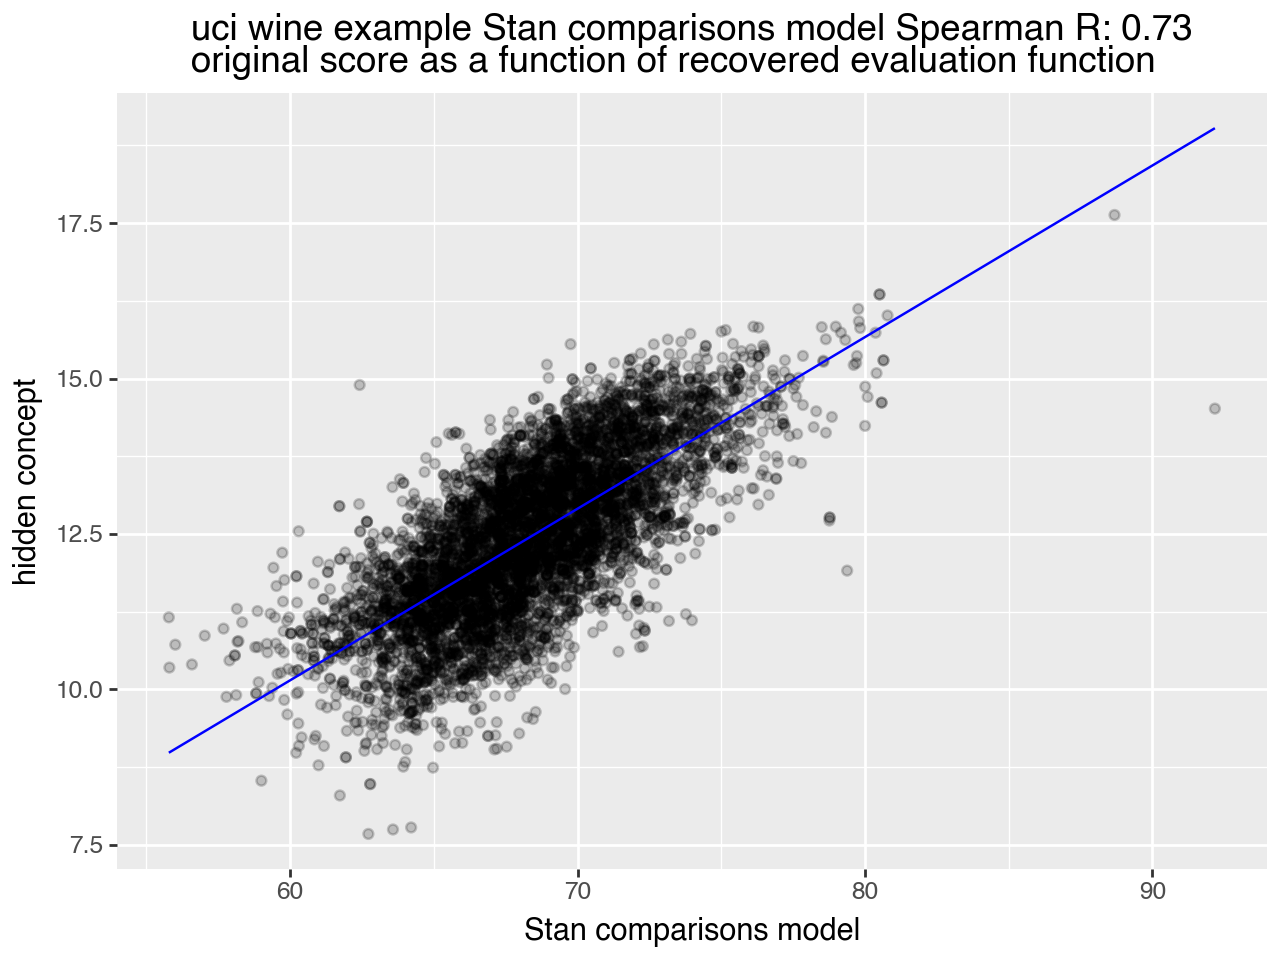

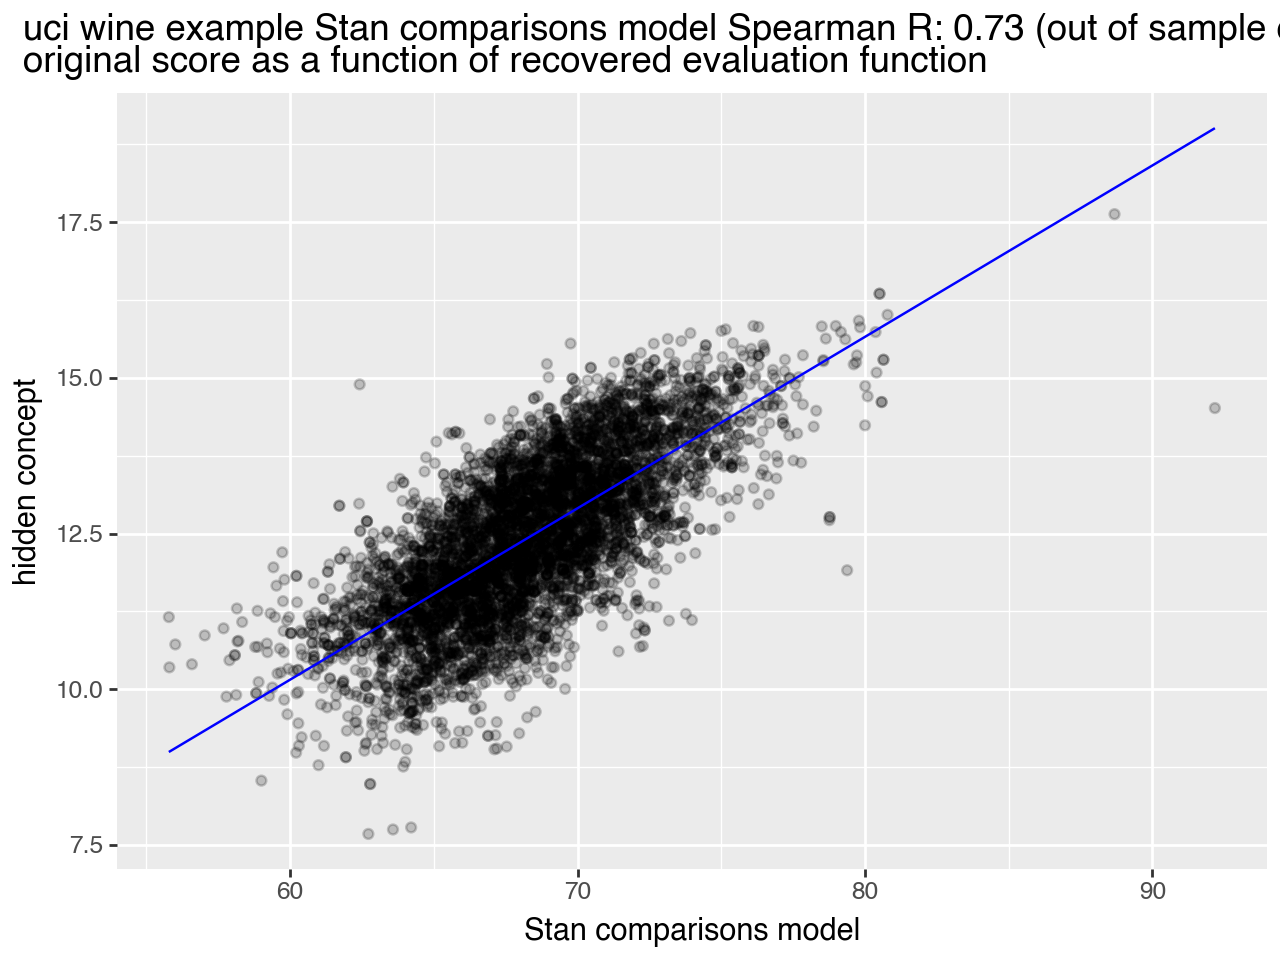

In [39]:
stat_pull = plot_rank_performance(
    estimated_beta=estimated_beta_Stan_c,  # estimated coefficients
    example_name=example_name,  # name of data set
    n_vars=n_vars,  # number of variables (including position variables)
    n_alternatives=n_alternatives,  # size of panels
    features_frame=features_frame,  # features by row id
    observations=observations,  # observations layout frame
    estimate_name="Stan comparisons model",  # display name of estimate
    position_quantiles=position_quantiles_c,  # quantiles of estimated positions
    position_penalties=position_penalties,  # ideal position penalties
    score_compare_frame=score_compare_frame,  # score comparison frame (altered by call)
    rng=rng,  # pseudo random source
    show_plots=do_display,
)
collected_stats.append(stat_pull)

In [40]:
collected_stats = pd.concat(collected_stats, ignore_index=True)

In [41]:
if (result_fname is not None) and (len(result_fname) > 0):
    collected_stats.to_csv(result_fname, index=False)

In [42]:
if do_display:
    display(collected_stats)

,example_name,estimate_name,SpearmanR_all,SpearmanR_test,pick_SpearmanR,pick_auc,data_size,test_size
0,uci wine example,Stan panel model,0.804331,0.804879,0.472644,0.841100,6497,6013
1,uci wine example,logistic model,0.720157,0.719287,0.466495,0.836662,6497,6013
2,uci wine example,Stan comparisons model,0.732010,0.731282,0.468366,0.838012,6497,6013
